In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from train import load_model
import theano
import lasagne
import theano.tensor as T
from lasagnekit.misc.plot_weights import dispims_color, tile_raster_images
from lasagnekit.misc.plot_weights import dispims_color
from lasagnekit.easy import iterate_minibatches

def minibatcher(X, f, size=128):
    res = []
    for sl in iterate_minibatches(X.shape[0], size):
        r = f(X[sl])
        res.append(r)
    return np.concatenate(res, axis=0)

/home/ubuntu/miniconda2/envs/python2/lib/python2.7/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
/home/ubuntu/work/code/external/scikit-learn/sklearn/cross_validation.py:43: DeprecationWarning: This module has been deprecated in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
x, z, gen_out, disc_out = load_model('out/lfw4/model.pkl')
# Good ones (64x64)
#d35958322a47dfb1ab74e899ca29c104
#50ef81c580c05ce045d9ab97804ad684 (good disc)
#d35958322a47dfb1ab74e899ca29c104
#2957e665383c5ab3d3aa4060bf38351e

# Good ones (32x32)
#b825e2af07f7115040c3bce115bd9050
#fff4e90c883aaa50dd86d5b74397c707
#2d5900178fb87433f5494eeeee620ba6
#b825e2af07f7115040c3bce115bd9050
#c804e38269889c787e66272a8e6d45ed

(None, 3, 64, 64)


In [3]:
disc_layers = lasagne.layers.get_all_layers(disc_out)
gen_layers = lasagne.layers.get_all_layers(gen_out)

In [4]:
X = T.tensor4()
discriminate = theano.function([X], lasagne.layers.get_output(disc_out, X))

In [6]:
Z = T.matrix()
generate = theano.function([Z], lasagne.layers.get_output(gen_out, Z))

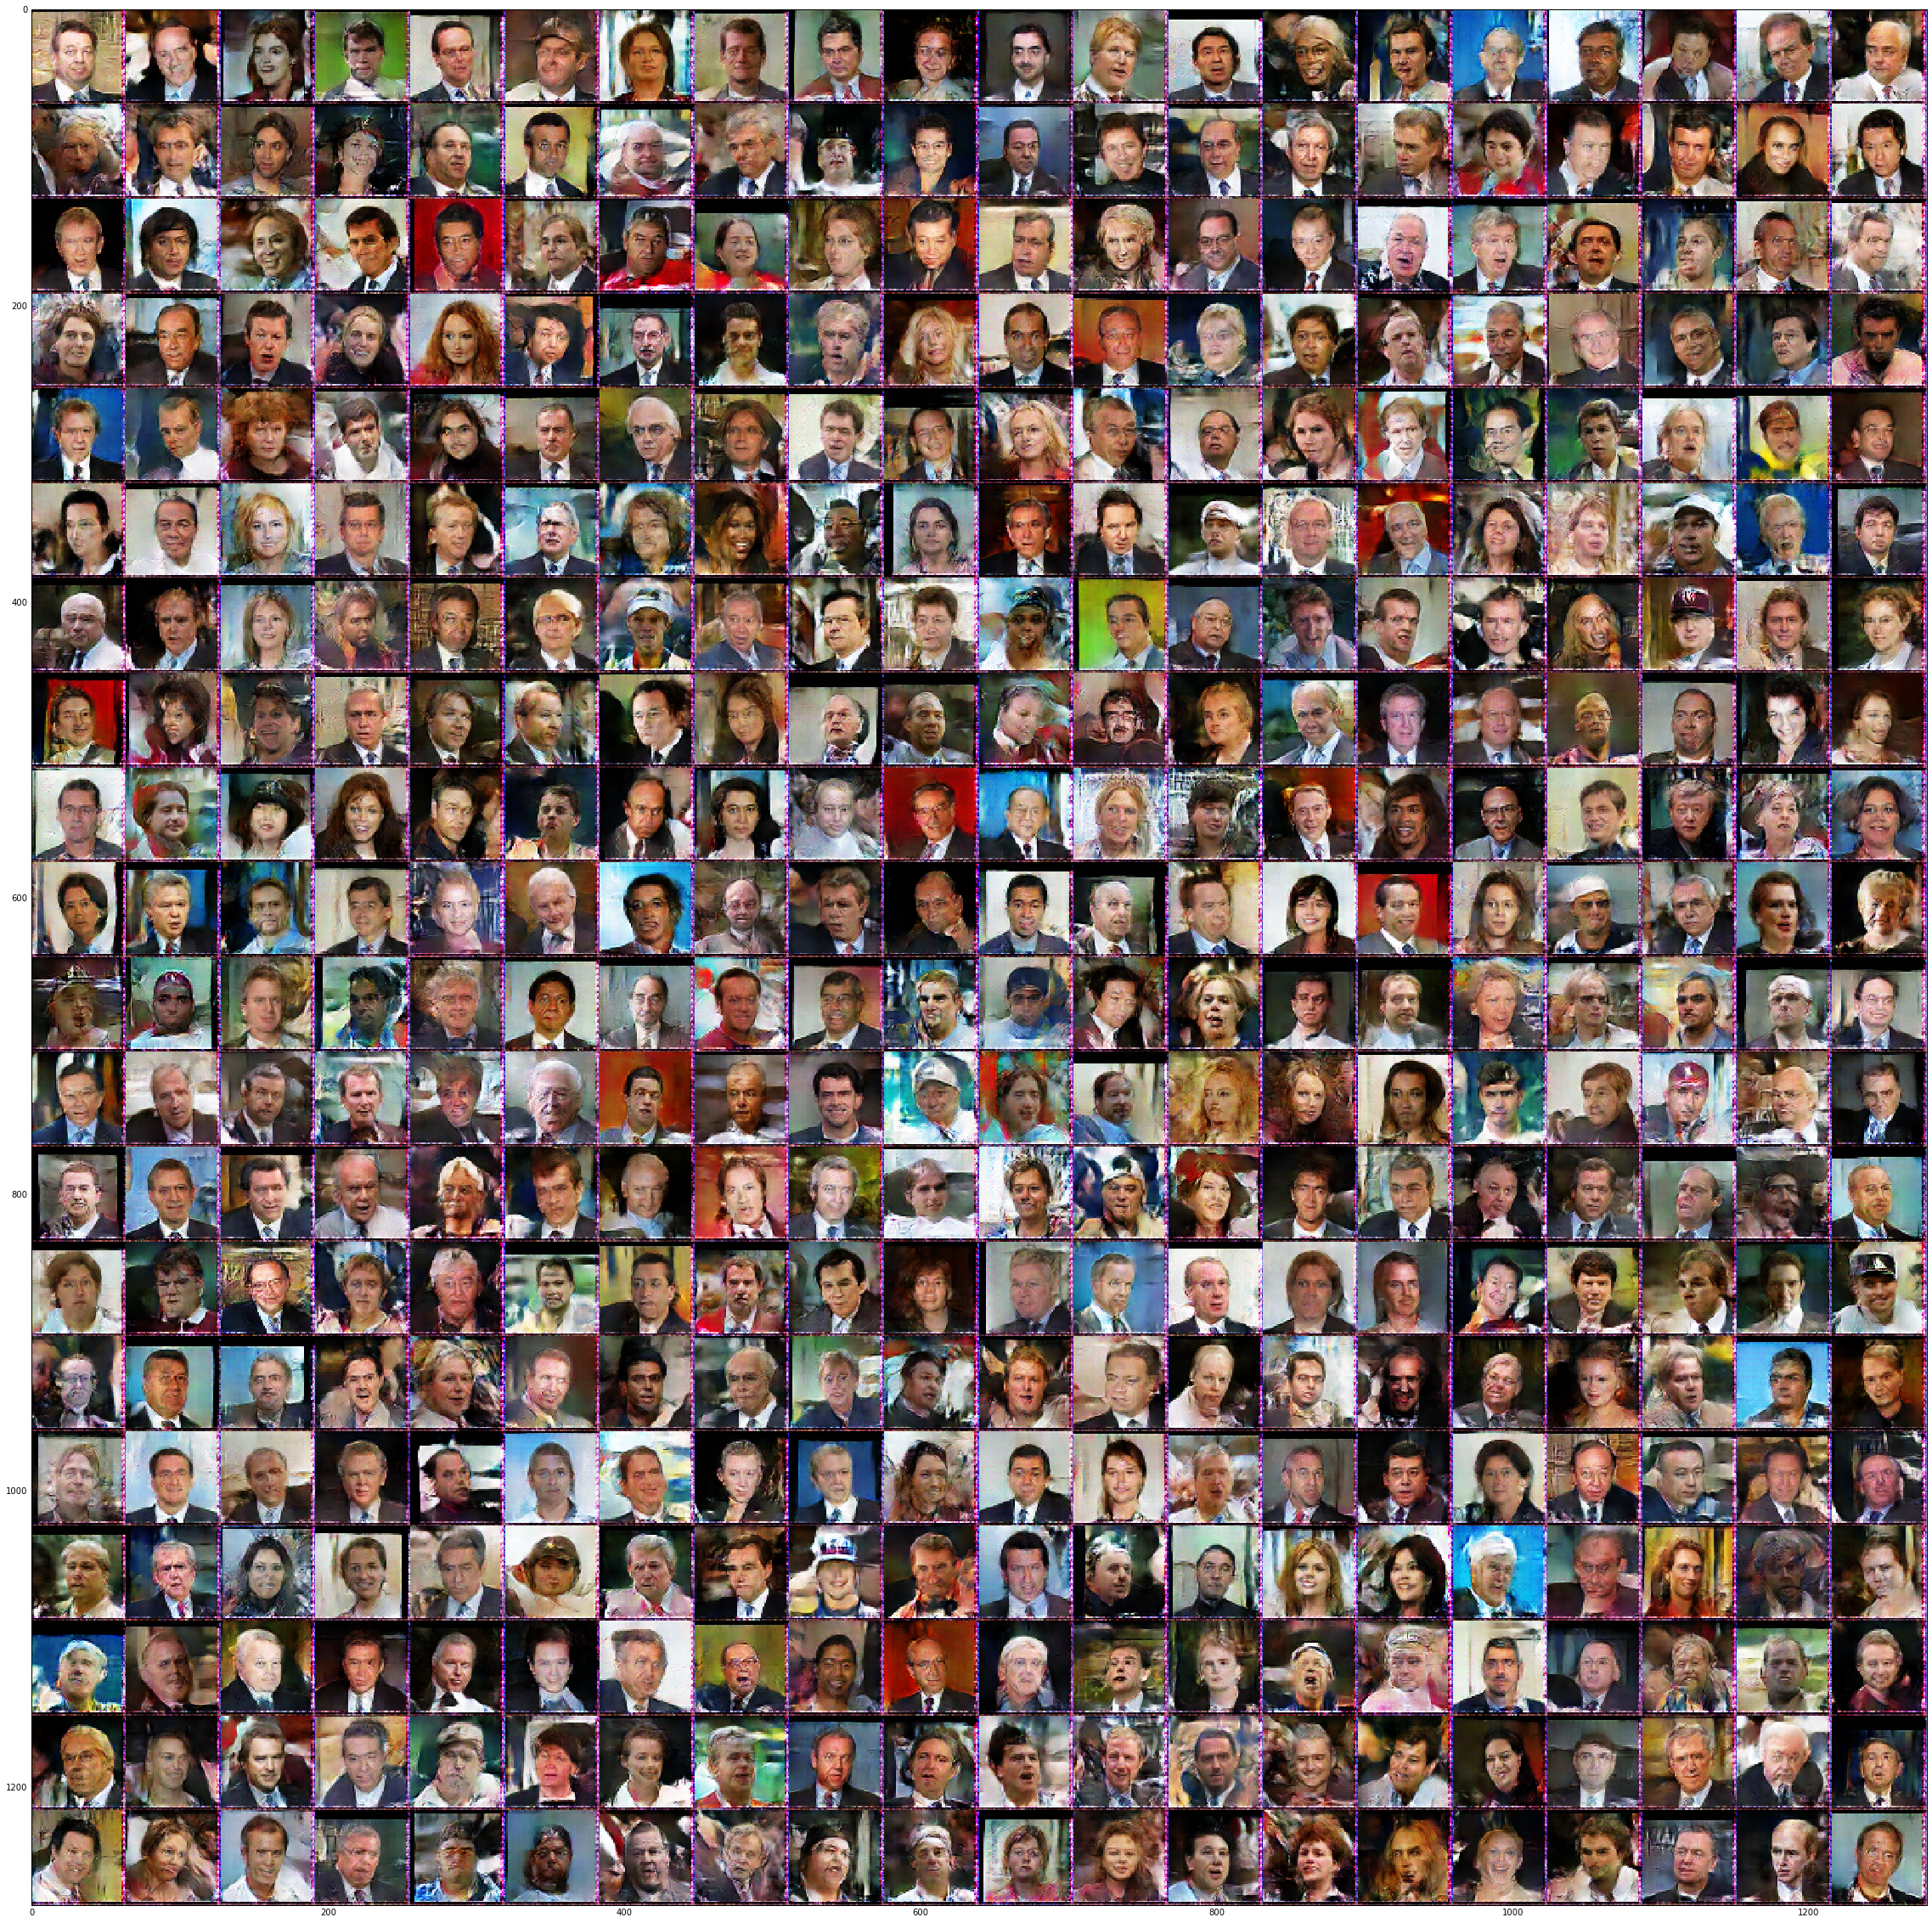

In [7]:
z = np.random.uniform(-1, 1, size=(400, 100))
xgen = generate(z)
xgen = xgen.transpose((0, 2, 3, 1)) * np.ones((1, 1, 1, 3))
img = dispims_color(xgen)
fig = plt.figure(figsize=(40, 40))
plt.imshow(img, interpolation='none')

In [40]:
from lasagnekit.datasets.fonts import Fonts
from lasagnekit.datasets.rescaled import Rescaled
data = Fonts()
data.load()
w, h = x.shape[2:]
data = Rescaled(data, (w, h))
data.load()
xfonts = data.X.reshape((data.X.shape[0], 1, w, h))

In [46]:
print(xfonts.shape)

(32968, 1, 64, 64)


In [ ]:
D = minibatcher(xfonts, discriminate, size=1000)
D_rand = minibatcher(np.random.uniform(size=xfonts.shape).astype(np.float32), discriminate, size=1000)

In [24]:
indices = np.argsort(D[:, 0])

NameError: name 'D' is not defined

In [ ]:
plt.hist(D_rand, normed=True, alpha=0.9, color='green', label='random')
plt.hist(D, normed=True, alpha=0.9, color='blue', label='fonts')
plt.legend()
plt.show()

In [ ]:
print((D_rand>0.9).mean())
print((D>0.9).mean())

In [ ]:
xx = xfonts[indices[::-1]][:, 0]
img = tile_raster_images(xx, (w, h), (50, 50))

fig = plt.figure(figsize=(20, 20))
plt.imshow(img, cmap='gray', interpolation='none')

## viz

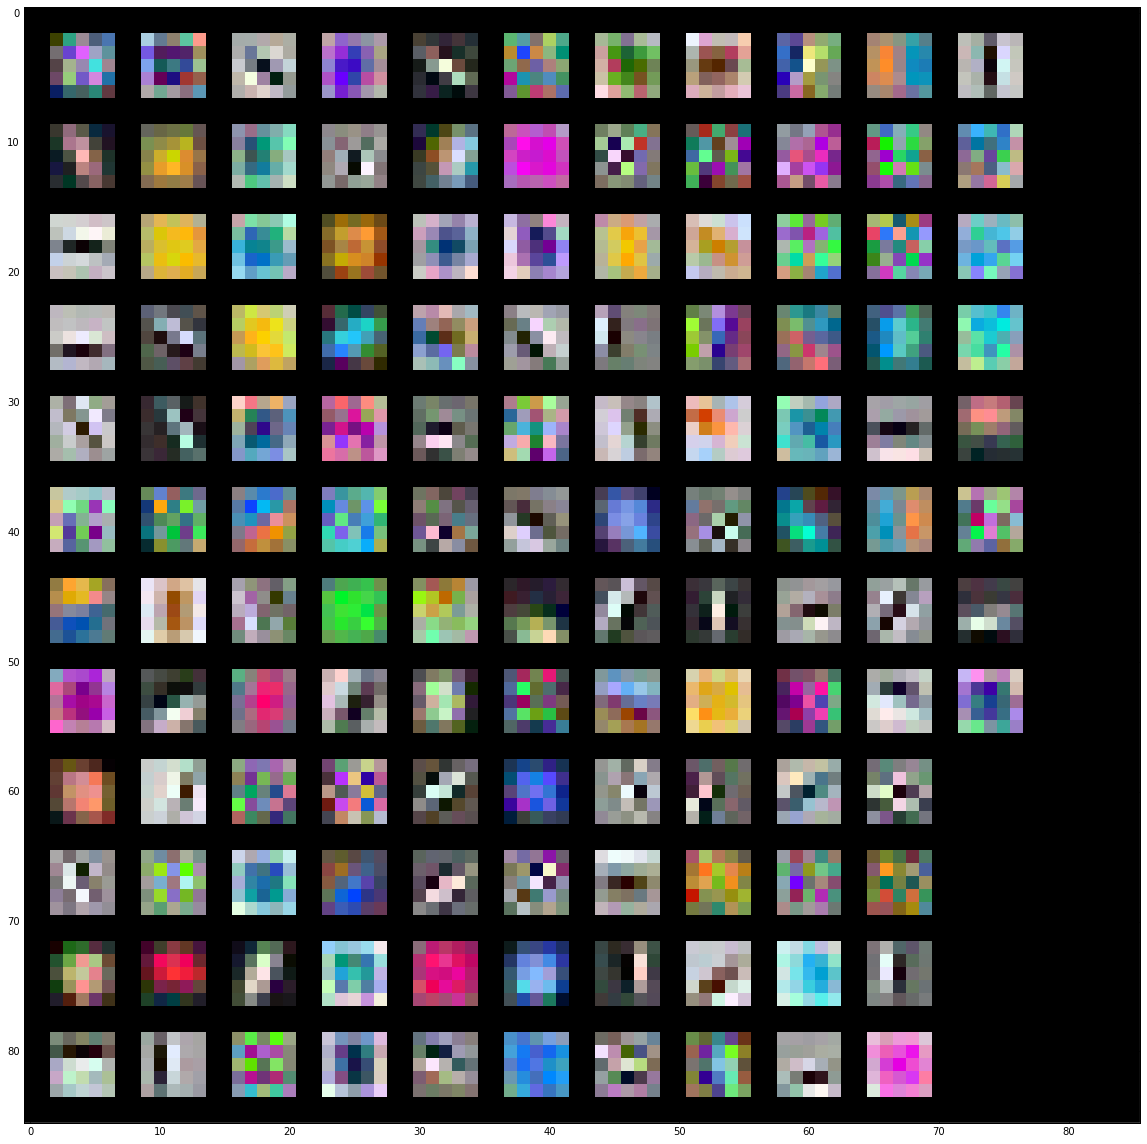

In [48]:
fig = plt.figure(figsize=(20, 20))
w = gen_layers[-1].W.get_value()
img = dispims_color(w.transpose((0, 2, 3, 1)) * np.ones((1, 1, 1, 3)), border=2)
plt.imshow(img, interpolation='none')

In [34]:
Z = T.matrix()
outs = lasagne.layers.get_output(gen_layers, Z)
get_layers = theano.function([Z], outs)

In [35]:
z = np.random.uniform(-1, 1, size=(400, 100))
l_x = get_layers(z)

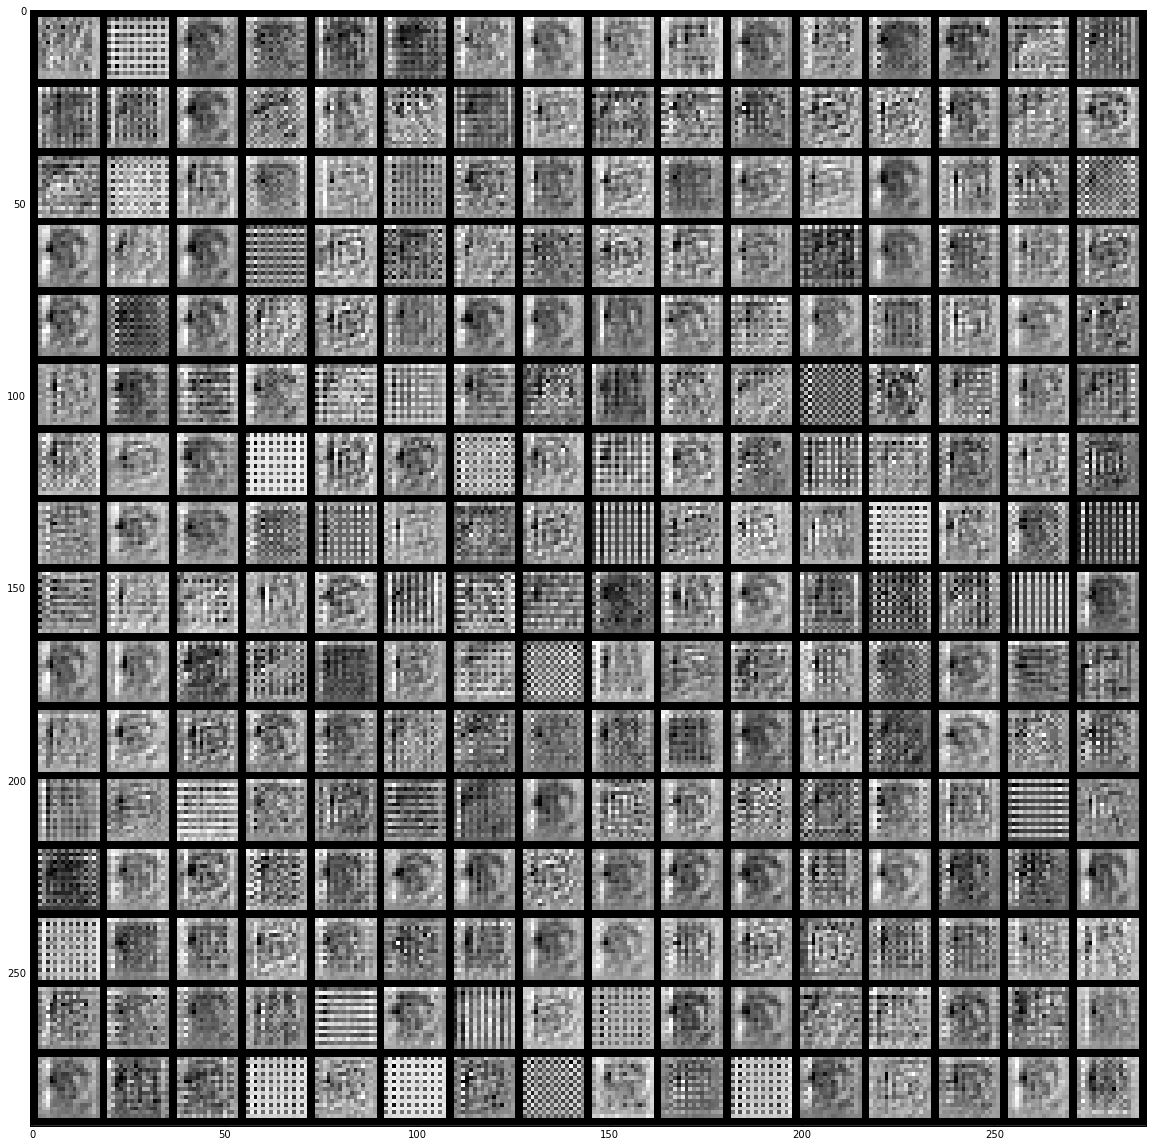

In [32]:
i = 9
img_index = 1
parts = l_x[i][img_index:img_index + 1]
parts = parts.reshape((parts.shape[0] * parts.shape[1], parts.shape[2], parts.shape[3]))
parts = parts[:, :, :, None] * np.ones((1, 1, 1, 3))
fig = plt.figure(figsize=(20, 20))
img = dispims_color(parts, border=2)
plt.imshow(img, cmap='gray', interpolation='none')

## Sliders

In [49]:
from collections import OrderedDict
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed
from IPython.display import Image
from skimage.transform import rescale
# Stdlib imports
from io import BytesIO

# Third-party libraries
from IPython.display import Image
from ipywidgets import interact, interactive, fixed, FloatSlider
import matplotlib as mpl
from skimage import data, filters, io
from collections import OrderedDict
def arr2img(arr):
    """Display a 2- or 3-d numpy array as an image."""
    if arr.ndim == 2:
        format, cmap = 'png', mpl.cm.gray
    elif arr.ndim == 3:
        format, cmap = 'jpg', None
    else:
        raise ValueError("Only 2- or 3-d arrays can be displayed as images.")
    # Don't let matplotlib autoscale the color range so we can control overall luminosity
    vmax = 255 if arr.dtype == 'uint8' else 1.0
    with BytesIO() as buffer:
        mpl.image.imsave(buffer, arr, format=format, cmap=cmap, vmin=0, vmax=vmax)
        out = buffer.getvalue()
    return Image(out)


In [38]:
## estimate the variance of each "hidden factor" :var(X|z_i)
nbins = 10
z_dim = 100
nb = 100
zvals = np.linspace(-1, 1, nbins)
c, w, h = gen_out.output_shape[1:]
means = np.zeros((z_dim, nbins, c*w*h))
sqr_means = np.zeros_like(means)
counts = np.zeros_like(means)

for i in range(100):
    z = np.random.uniform(-1, 1, size=(nb, z_dim))
    x = generate(z)
    for j in range(z_dim):
        for k in range(nb):
            idx = np.argmin(np.abs(zvals - z[k, j]))
            means[j, idx, :] = (x[k].flatten() + counts[j, idx] * means[j, idx]) / (counts[j, idx] + 1)
            sqr_means[j, idx, :] = (x[k].flatten() + counts[j, idx] * sqr_means[j, idx]) / (counts[j, idx] + 1)
            counts[j, idx] += 1

In [ ]:
var = sqr_means - means**2
print(np.argsort(var.sum(axis=(1, 2))))

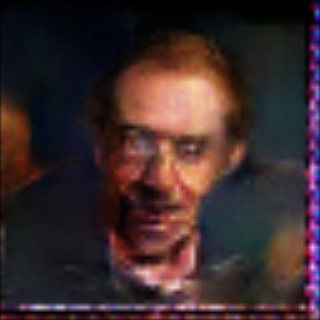

In [50]:
#np.random.seed(100)
nb = 128
c, w, h = gen_out.output_shape[1:]

z = np.random.uniform(-1, 1, size=(nb, 100))
img = np.random.uniform(size=(nb, c, w, h))

def redraw(**kw):
    for k, v in kw.items():
        z[0, int(k)] = v
    xgen = generate(z)
    xgen = xgen.transpose((0, 2, 3, 1)) * np.ones((1, 1, 1, 3))
    xgen = xgen[0:1]
    img = dispims_color(xgen)
    img = rescale(img, 5)
    return arr2img(img)

redraw.func_defaults = tuple(z[0])
kw = OrderedDict()
#dims = [0, 51, 32, 7, 47, 79, 85, 74]
dims = np.arange(10)
for i in dims:
    kw[str(i)] = FloatSlider(min=-1, max=1, value=z[0, i])

interactive(redraw, **kw)

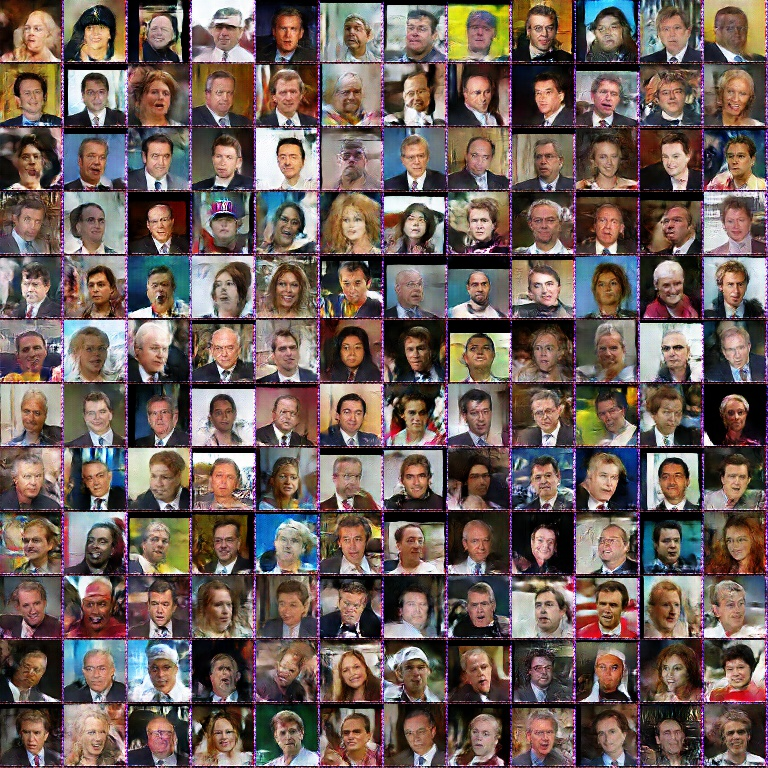

In [52]:
#np.random.seed(100)
nb = 12*12
c, w, h = gen_out.output_shape[1:]
z_dim = 100
img = np.random.uniform(size=(nb, c, w, h))

def redraw(scale=1):
    z = np.random.uniform(-scale, scale, size=(nb, z_dim))
    z = np.random.normal(loc=scale, size=(nb, z_dim))
    xgen = generate(z)
    xgen = xgen.transpose((0, 2, 3, 1)) * np.ones((1, 1, 1, 3))
    #xgen = xgen[0:1]
    img = dispims_color(xgen)
    #img = rescale(img, 5)
    return arr2img(img)

redraw.func_defaults = tuple(z[0])
kw = OrderedDict()
interactive(redraw, scale=(0.001, 100, 0.01))

## video

In [53]:
from tempfile import mkdtemp
import shutil
import os
import sys
import subprocess

from skimage.io import imsave

cmd_tpl = 'ffmpeg -y -framerate {framerate} -i {pattern} -c:v libx264 -r {rate} -pix_fmt yuv420p {out}'


def imgs_to_video(imgs, out='out.mp4', framerate=20, rate=20, verbose=0):
    """
    Utility function to convert a set of images to a video.
    images are represented by a 3D tensor of shape (nbimages, w, h) or
    (nbimages, w, h, 3) for colored images.
    Warning : this will overwrite the file out if it already exists.

    Assumes 'ffmpeg' is installed.

    imgs : 3D tensor of shape (nbimages, w, h) or (nbimages, w, h, 3)
    out : output file to write
    framerate : framerate of input (ffmpeg option)
    rate : rate (ffmpeg option)
    verbose : turn to 1 to see the details
    """
    out = os.path.abspath(out)
    dirname = mkdtemp(prefix='img_to_video')
    for i, img in enumerate(imgs):
        filename = os.path.join(dirname, 'img{:08d}.png'.format(i))
        imsave(filename, img)
    params = dict(
        framerate=framerate,
        pattern='img%08d.png',
        rate=rate,
        out=out
    )
    cmd = cmd_tpl.format(**params)
    if verbose > 0:
        stdout = None
        print(cmd)
    else:
        stdout = open(os.devnull, 'w')
    subprocess.call(cmd, shell=True, cwd=dirname, stdout=stdout, stderr=stdout)
    shutil.rmtree(dirname)

In [54]:
nb = 64
z_dim = 100

z = np.random.uniform(-1, 1, size=(nb, z_dim))

imgs = []
for i in range(1000):
    z += np.random.normal(0, 0.05, size=z.shape)
    xgen = generate(z)
    xgen = xgen.transpose((0, 2, 3, 1)) * np.ones((1, 1, 1, 3))
    #xgen = xgen[0:1]
    img = dispims_color(xgen)
    imgs.append(img)

In [13]:
imgs_to_video(imgs, 'out.mp4')